# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
cmap = dict()
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, PowerNorm
count = 0
for key in colors.cnames:
    if 'dark' in key:
    #if key in key:
        cmap[count] = key
        count = count + 1
#cmap = {'black': 0, 'red': 1, 'blue': 2, 'green': 3}
cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}
import os
import numpy as np
import pandas as pd

import astropy.coordinates as c
import astropy.wcs as wcs
import astropy.units as u
import matplotlib.pyplot as plt

# Functions

In [2]:
def compute_psf(data, ebins, radius):
    nbin = len(ebins) - 1
    psf = np.zeros(nbin)
    psf_err = np.zeros(nbin)
    for idx in range(nbin):
        emin = ebins[idx]
        emax = ebins[idx+1]
        sel = data.loc[(data['mc_energy'] >= emin) & (data['mc_energy'] < emax), ['xi']]
        if len(sel) != 0:
            psf[idx] = np.percentile(sel['xi'], radius)
            psf_err[idx] = psf[idx] / np.sqrt(len(sel))
        else:
            psf[idx] = 0.
            psf_err[idx] = 0.
    return psf, psf_err

def plot_psf(ax, x, y, err, **kwargs):
    color = kwargs.get('color', 'red')
    label = kwargs.get('label', '')
    xlabel = kwargs.get('xlabel', '')
    xlim = kwargs.get('xlim', None)
    
    ax.errorbar(x, y, yerr=err, fmt='o', label=label, color=color) #, yerr=err, fmt='o') #, color=color, label=label)
    ax.set_ylabel('PSF (68% containment)')
    ax.set_xlabel('True energy [TeV]')
    if xlim is not None:
        ax.set_xlim(xlim)
    return ax

# Load data

In [3]:
data_dir = '../data/DL2'
data_file = 'dl2_tail_gamma_merged.h5'
data_evt = pd.read_hdf(os.path.join(data_dir, data_file), "/reco_events")

# Plot PSF

<Figure size 2000x2000 with 0 Axes>

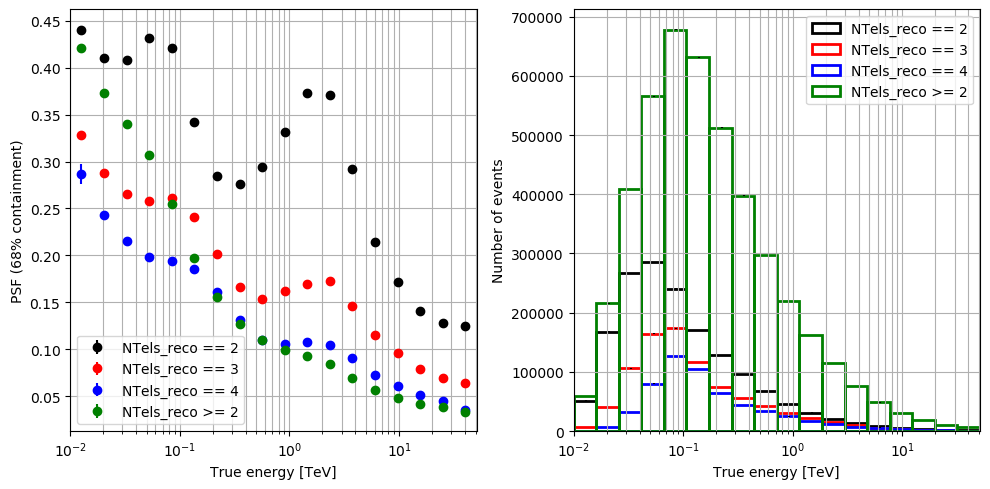

In [4]:
r_containment = 68

energy_edges = np.logspace(np.log10(0.01), np.log10(51), 18 + 1, True)
energy = np.sqrt(energy_edges[1:] * energy_edges[:-1])
multiplicity_cuts = ['NTels_reco == 2','NTels_reco == 3', 'NTels_reco == 4', 'NTels_reco >= 2']

plt.figure(figsize=(20,20))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes = axes.flatten()

cmap = {0: 'black', 1: 'red', 2: 'blue', 3: 'green'}

limit = [0.01, 51]
for cut_idx, cut in enumerate(multiplicity_cuts):
    data_mult = data_evt.query(cut)
    psf, err_psf = compute_psf(data_mult, energy_edges, 68)
    opt={'color': cmap[cut_idx], 'label': multiplicity_cuts[cut_idx]}
    plot_psf(axes[0], energy, psf, err_psf, **opt)
    
    y, tmp = np.histogram(data_mult['mc_energy'], bins=energy_edges)
    weights = np.ones_like(y)
    #weights = weights / float(np.sum(y))
    yerr = np.sqrt(y) * weights
    centers = 0.5 * (energy_edges[1:] + energy_edges[:-1])
    width = energy_edges[1:] - energy_edges[:-1]
    axes[1].bar(centers, y * weights, width=width, yerr=yerr, **{'edgecolor': cmap[cut_idx], 'label': multiplicity_cuts[cut_idx], 'lw': 2, 'fill': False})
    axes[1].set_ylabel('Number of events')
    
for ax in axes:
    ax.set_xlim(limit)
    ax.set_xscale('log')
    ax.legend(loc='best')
    ax.grid(which='both')
    ax.set_xlabel('True energy [TeV]')

plt.tight_layout()
plt.savefig('psf_{}.pdf')
plt.savefig('psf_{}.png')

# PSF Asymetry

/Users/michele/anaconda3/envs/protopipe_ctapipe062/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  from ipykernel import kernelapp as app


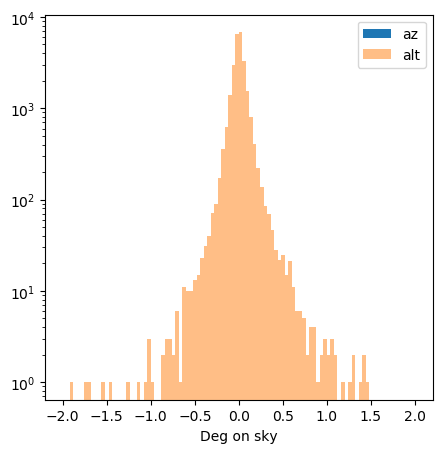

In [5]:
data = data_evt[ (data_evt.mc_energy > 0.05) & (data_evt.NTels_reco_lst > 2) ].copy().head(26013)
data.loc[data_evt.reco_az<-180, 'reco_az'] += 360.0
data['reco_az_sky'] = data.reco_az * np.cos(np.deg2rad(data.reco_alt))

CENTER_ALT_DEG = 70.0
CENTER_AZ_DEG = 0.0

dalt = data.reco_alt - CENTER_ALT_DEG
daz = data.reco_az_sky - CENTER_AZ_DEG


the_range = [-2,2]
plt.figure(figsize=(5,5))
plt.semilogy()
plt.hist(daz, bins=100, range=the_range, label='az')
plt.hist(dalt, bins=100, range=the_range, alpha=0.5, label='alt')
plt.xlabel("Deg on sky")
plt.legend()
plt.savefig('alt_az_{}.pdf')

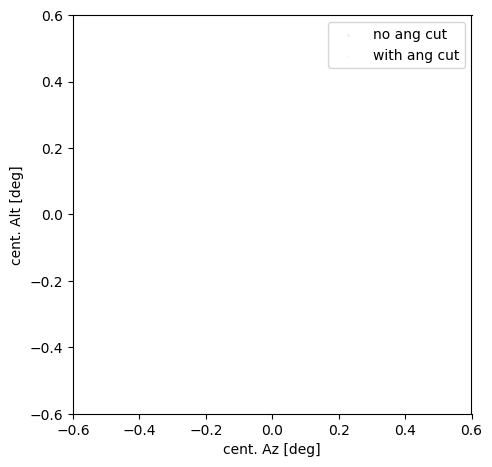

In [6]:
angcut = data['offset'] < 0.05
dx = 0.3
plt.figure(figsize=(5,5))
ax = plt.gca()
ax.scatter(daz, dalt, alpha=0.1, s=1, label='no ang cut')
ax.scatter(daz[angcut], dalt[angcut], alpha=0.05, s=1, label='with ang cut')
ax.set_aspect('equal')
ax.set_xlim(-2*dx,2*dx)
ax.set_ylim(-2*dx,2*dx)
ax.legend()
ax.set_xlabel('cent. Az [deg]')
ax.set_ylabel('cent. Alt [deg]')
plt.tight_layout()
plt.savefig('2d_alt_az_{}.png')

In [ ]:
print('daz = {:.4f} +/- {:.4f}'.format(daz.mean(), daz.std()))
print('dalt = {:.4f} +/- {:.4f}'.format(dalt.mean(), dalt.std()))